In [112]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [113]:
import pathlib
data_dir = pathlib.Path('Detectar autos')

In [114]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

107


Tamaño de imagen

In [115]:
batch_size = 32
img_height = 180
img_width = 180

In [116]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 107 files belonging to 5 classes.
Using 86 files for training.


In [117]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 107 files belonging to 5 classes.
Using 21 files for validation.


In [118]:
class_names = train_ds.class_names
print(class_names)

['camioneta_familiar', 'deportivo', 'motocicleta', 'sedan', 'taxi']


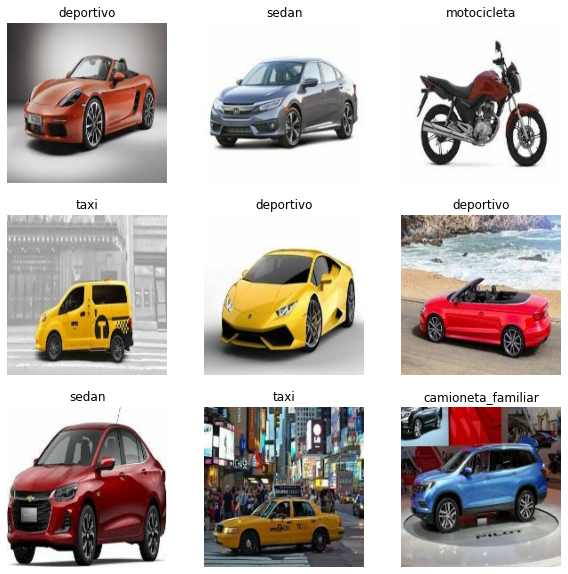

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [120]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [121]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [122]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [123]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=6
)

Epoch 1/6
3/3 [==============================] - 1s 349ms/step - loss: 2.0395 - accuracy: 0.1744 - val_loss: 1.7018 - val_accuracy: 0.1905
Epoch 2/6
3/3 [==============================] - 1s 244ms/step - loss: 1.5841 - accuracy: 0.2674 - val_loss: 1.6468 - val_accuracy: 0.0952
Epoch 3/6
3/3 [==============================] - 1s 240ms/step - loss: 1.5495 - accuracy: 0.3837 - val_loss: 1.6525 - val_accuracy: 0.2381
Epoch 4/6
3/3 [==============================] - 1s 251ms/step - loss: 1.4575 - accuracy: 0.5930 - val_loss: 1.5957 - val_accuracy: 0.3810
Epoch 5/6
3/3 [==============================] - 1s 256ms/step - loss: 1.3222 - accuracy: 0.7209 - val_loss: 1.5145 - val_accuracy: 0.4762
Epoch 6/6
3/3 [==============================] - 1s 250ms/step - loss: 1.1308 - accuracy: 0.7093 - val_loss: 1.4135 - val_accuracy: 0.4286


In [124]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [125]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['camioneta_familiar' 'deportivo' 'motocicleta' 'sedan' 'taxi']


In [126]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [127]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [128]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [129]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [130]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [131]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


In [132]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

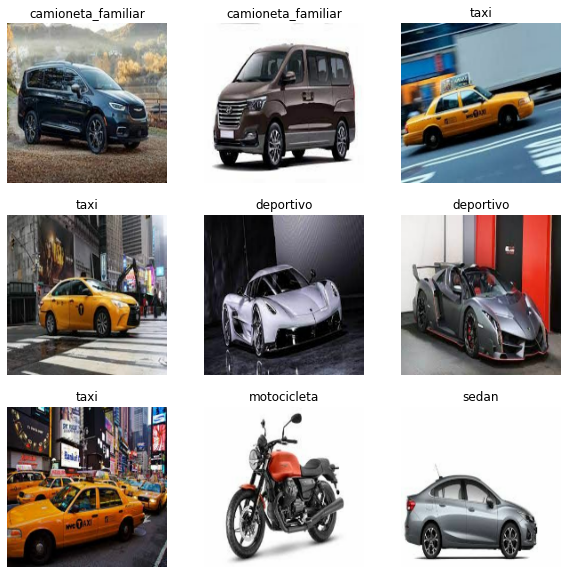

In [133]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [134]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
3/3 [==============================] - 1s 300ms/step - loss: 0.9488 - accuracy: 0.6744 - val_loss: 0.9733 - val_accuracy: 0.6190
Epoch 2/5
3/3 [==============================] - 1s 260ms/step - loss: 0.7110 - accuracy: 0.8140 - val_loss: 0.7834 - val_accuracy: 0.8095
Epoch 3/5
3/3 [==============================] - 1s 244ms/step - loss: 0.5454 - accuracy: 0.8605 - val_loss: 1.2635 - val_accuracy: 0.5714
Epoch 4/5
3/3 [==============================] - 1s 254ms/step - loss: 0.5212 - accuracy: 0.8140 - val_loss: 0.7010 - val_accuracy: 0.7143
Epoch 5/5
3/3 [==============================] - 1s 263ms/step - loss: 0.3118 - accuracy: 0.9070 - val_loss: 0.7174 - val_accuracy: 0.7619


In [135]:
foto = pathlib.Path(r'Prueba/sedan.jpg')

img = tf.keras.utils.load_img(
    foto, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "El tipo de auto es: {} "
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 54ms/step
El tipo de auto es: deportivo 
